<a href="https://colab.research.google.com/github/amirkasaei/Image-Segemntation-CamVid/blob/main/SegNet_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [6]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Activation, add, ZeroPadding2D, UpSampling2D, concatenate, Reshape
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.image import resize
from copy import deepcopy


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.model_selection import KFold

import copy
import imageio
import PIL.Image as Image

import os
import sys
import time
import cv2 as cv

**GPU**

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# **Preprocess**

### **Google Drive mount**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path = '/content/drive/MyDrive/AI/Deep Learning/CamVid/'

### **Data Visualization**

In [10]:
img = np.array(load_img(path + 'camvid/images/' + '0001TP_006690.png'))
mask = np.array(load_img(path + 'LabeledApproved/' + '0001TP_006690_L.png'))

In [11]:
original_input_shape = np.array(img).shape
original_input_shape

(720, 960, 3)

Text(0.5, 1.0, 'Mask')

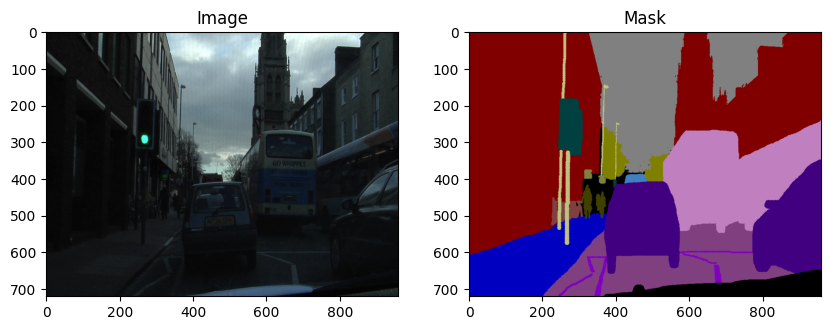

In [12]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

In [13]:
scale = 0.16666
resized_img = cv.resize(img, (0,0), fx=scale, fy=scale)/255.0
resized_mask = cv.resize(mask, (0,0), fx=scale, fy=scale)
resized_img.shape

(120, 160, 3)

Text(0.5, 1.0, 'Mask')

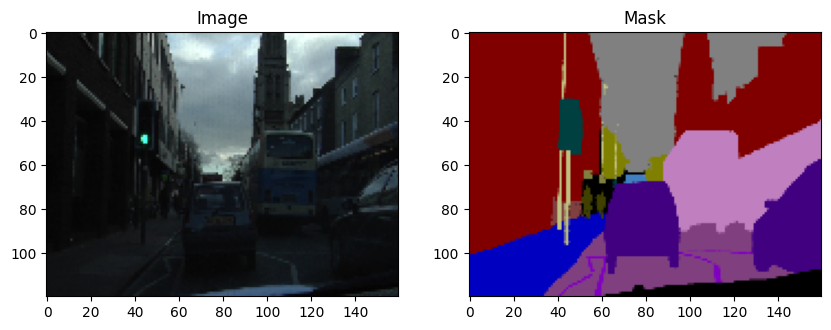

In [14]:
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(resized_img)
arr[0].set_title('Image')
arr[1].imshow(resized_mask)
arr[1].set_title('Mask')

### **Feature Adjustment**

In [15]:
classes = pd.read_csv(path + 'class_dict.csv', index_col =0)
classes

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


In [16]:
n_classes = len(classes)
n_classes

32

In [17]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}

In [18]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}

In [19]:
def adjust_mask(mask, flat=False):
    semantic_map = []
    for colour in list(cls2rgb.values()):
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.

    if flat:
      semantic_map = np.reshape(semantic_map, (-1, 144*192))

    return np.float32(semantic_map)# convert to numbers

In [20]:
# Map the idx back to rgb
def map_class_to_rgb(p):
  return idx2rgb[p[0]]

In [21]:
def unadjust_mask(new_mask):
  return np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))

In [22]:
#convert orgignal image
new_mask = adjust_mask(resized_mask)
new_mask.shape

(120, 160, 32)

In [23]:
rgb_mask = unadjust_mask(new_mask)

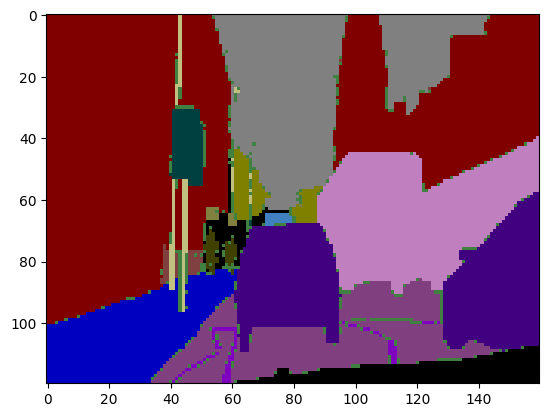

In [24]:
plt.imshow(rgb_mask)

### **Load images**

In [25]:
flat = False

In [26]:
images, masks = [], []
for filename in os.listdir(path + 'camvid/images/'):

    img = np.array(load_img(path + 'camvid/images/' + filename))

    mask = np.array(load_img(path + 'LabeledApproved/' + filename[:-4] + '_L.png'))

    if img is not None and mask is not None:
      img = cv.resize(mask, (0,0), fx=scale, fy=scale)/255.0

      mask = cv.resize(mask, (0,0), fx=scale, fy=scale)
      mask = adjust_mask(mask)

      images.append(img)
      masks.append(mask)

In [27]:
# images = np.array(images)
# masks = np.array(masks)

### **Feature Selection**

In [28]:
# x = images
# y = masks
# if(flat):
#   y = np.reshape(len(y), len(y[1])*len(y[1]))
#   y = np.expand_dims(masks, axis=-1)

In [29]:
input_shape = images[0].shape
input_shape

(120, 160, 3)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images), np.array(masks), test_size=0.1)

In [31]:
y_test.shape

(71, 120, 160, 32)

In [32]:
x_train.shape, y_train.shape

((630, 120, 160, 3), (630, 120, 160, 32))

# **Model**

## **Instruction**

In [33]:
kernel_size = 7
filter_size = 64
pad = 1
pool_size = 2
height = input_shape[0]
width = input_shape[1]
data_shape = input_shape[0]*input_shape[1]

In [34]:
inputs = Input(shape=input_shape)
# ------------------------------------ down 1----------------------------------------
conv1 = Conv2D(filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
# conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
bn1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
# ------------------------------------ down 2 ----------------------------------------
conv2 = Conv2D(2*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
# conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
bn2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
# ------------------------------------ down 3 ----------------------------------------
conv3 = Conv2D(4*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
# conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
bn3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
# ------------------------------------ down 4 ----------------------------------------
conv4 = Conv2D(8*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
# conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
bn4 = BatchNormalization()(conv4)

# ------------------------------------ up 1 ----------------------------------------
up5 = Conv2D(8*filter_size, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn4)
conv5 = Conv2D(8*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up5)
# conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
bn5 = BatchNormalization()(conv5)
# ------------------------------------ up 2 ----------------------------------------
up6 = Conv2D(4*filter_size, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn5))
conv6 = Conv2D(4*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up6)
# conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
bn6 = BatchNormalization()(conv6)
# ------------------------------------ up 3 ----------------------------------------
up7 = Conv2D(2*filter_size, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn6))
conv7 = Conv2D(2*filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
# conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
bn7 = BatchNormalization()(conv7)
# ------------------------------------ up 4 ----------------------------------------
up8 = Conv2D(filter_size, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(bn7))
conv8 = Conv2D(filter_size, kernel_size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
# conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
bn8 = BatchNormalization()(conv8)

convOut = Conv2D(n_classes, (1,1), padding='same')(bn8)

if flat:
  outputs = Reshape((data_shape,n_classes))(convOut)
else:
  outputs = convOut

outputs = Activation('softmax')(outputs)


segnet = Model(inputs, outputs)

segnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 160, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 120, 160, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 80, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 128)       401536    
                                                                 
 batch_normalization_1 (Batc  (None, 60, 80, 128)      512   

In [35]:
segnet.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

## **Train**

In [36]:
with tf.device('/GPU:0'):
  segnet.fit(x_train, y_train, validation_split=0.1, epochs=30, verbose=2, batch_size=16)

Epoch 1/30
36/36 - 55s - loss: 1.1966 - accuracy: 0.7057 - val_loss: 1.7165 - val_accuracy: 0.6172 - 55s/epoch - 2s/step
Epoch 2/30
36/36 - 16s - loss: 0.6133 - accuracy: 0.8325 - val_loss: 1.4917 - val_accuracy: 0.6337 - 16s/epoch - 435ms/step
Epoch 3/30
36/36 - 15s - loss: 0.4851 - accuracy: 0.8566 - val_loss: 1.2484 - val_accuracy: 0.6774 - 15s/epoch - 429ms/step
Epoch 4/30
36/36 - 16s - loss: 0.4135 - accuracy: 0.8696 - val_loss: 1.1078 - val_accuracy: 0.7205 - 16s/epoch - 437ms/step
Epoch 5/30
36/36 - 16s - loss: 0.3558 - accuracy: 0.8810 - val_loss: 1.0018 - val_accuracy: 0.7258 - 16s/epoch - 441ms/step
Epoch 6/30
36/36 - 16s - loss: 0.3181 - accuracy: 0.8883 - val_loss: 0.7889 - val_accuracy: 0.7674 - 16s/epoch - 438ms/step
Epoch 7/30
36/36 - 16s - loss: 0.2962 - accuracy: 0.8923 - val_loss: 0.6380 - val_accuracy: 0.8058 - 16s/epoch - 439ms/step
Epoch 8/30
36/36 - 16s - loss: 0.2729 - accuracy: 0.8974 - val_loss: 0.5465 - val_accuracy: 0.8209 - 16s/epoch - 440ms/step
Epoch 9/30


## **Evaluation**

In [37]:
segnet.evaluate(x_test, y_test, batch_size=32)

3/3 [==============================] - 8s 127ms/step - loss: 0.2347 - accuracy: 0.9007


[0.23473785817623138, 0.9006733894348145]

In [38]:
pred = segnet.predict(x_test)

3/3 [==============================] - 1s 177ms/step


In [39]:
pred.shape

(71, 120, 160, 32)

In [40]:
rgb_mask = unadjust_mask(pred[0])

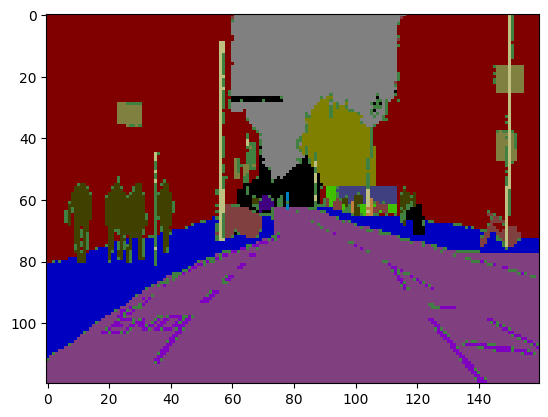

In [41]:
plt.imshow(unadjust_mask(y_test[0]))

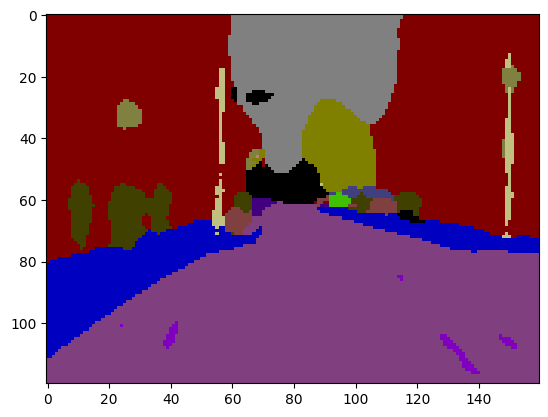

In [42]:
plt.imshow(rgb_mask)